# LambdaCMD model

Now, to begin the program I want to do a simple case: LambdaCDM model, but I vary only H0 and omega matter so far.

In this case I have redshifts z took by the binned_data and I will use as distance the distances computed with the formula (like error to put in sigma we will use the data file)

In [8]:
import sys
sys.path.append("../")

import numpy as np
import math as m
from scipy.optimize import minimize
import sys
import platform
import os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import camb
import pandas as pd

# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa, Dc_w

from scipy.optimize import minimize #to make best fit of the chi square




In [9]:
# READ THE DATA
# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

In [10]:
# Implement your favourite Hubble function
def hubble_function(z,omega_mat,omega_rad,w,H0):
    return H0*m.sqrt(omega_mat*(1+z)**3 + omega_rad*(1+z)**4 + (1 - omega_mat - omega_rad)*(1+z)**(3*(1+w)))

In [11]:
# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z_lista = data['zcmb'].values



mu = []
for z_prime in z_lista:
    mu.append(5*np.log10(Dc(hubble_function,z_prime,0.319,0,-1,68)*(1+z_prime)) + 25)

data['mb'] = mu
# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0 = params #, w0, wa
    #print(H0, Om0)
    if Om0 < 0:
        return -np.inf
    z = data['zcmb'].values
    d = data['mb'].values 
    mu = []
    for z_prime in z:
        mu.append(5*np.log10(Dc(hubble_function,z_prime,Om0,0,-1,H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)

In [12]:
# Example data and covariance inverse matrix
z = data['zcmb'].values
d = data['mb'].values +19.3
dmb = data['dmb'].values
#error_mb = np.ones(len(dmb)) 

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [70, 0.3]
print(neg_ln_likelihood([68, 0.319], data, np.linalg.inv(np.diag(dmb**2))))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
best_fit_params = result.x
print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(result)

2024-07-24 22:24:00.395581 :: pyACC.CosmologicalDistances  :: -0.0


/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


2024-07-24 22:24:15.809757 :: pyACC.CosmologicalDistances  :: Optimized Parameters: [68.     0.319]
2024-07-24 22:24:15.810115 :: pyACC.CosmologicalDistances  :: Optimized Log Likelihood: -4.1264067313116258e-25
2024-07-24 22:24:15.810234 :: pyACC.CosmologicalDistances  :: Best fit parameters: H0 = 67.99999999999994, Om0 = 0.3190000000000056
2024-07-24 22:24:15.810299 :: pyACC.CosmologicalDistances  ::  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.1264067313116258e-25
       x: [ 6.800e+01  3.190e-01]
     nit: 7
   direc: [[-5.293e-02  4.203e-03]
           [ 6.723e-14 -2.253e-16]]
    nfev: 226


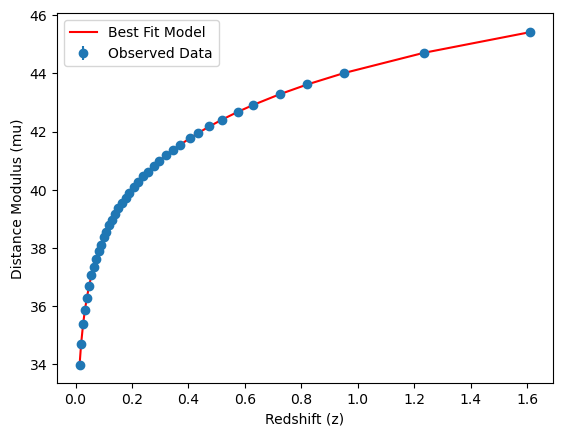

In [13]:
# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Om0_best = best_fit_params
mu_best = []
for z_prime in z:
    #mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, Om0_best, 0, -1, H0_best) * (1 + z_prime)) + 25)
    mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, 0.319, 0, -1, 68.) * (1 + z_prime)) + 25)

# mb is mu +19.3, so:
y = data['mb'].values # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()

# End of the first part

# LambdaCDM model with more parameters

Steps:
* 1- Set the cosmology: H0=67.5, ombh2=0.022, omch2=0.122, omk=0, omrh2= 2.47*10^-5(this values is taken by internet), omega_Lambda = 0.681, w0 = -0.5, wa = -1.3   * 
* 2- Compute the distances modulus for each redshifts z took by the file "binned_data" (40 values)
* 3- Compute the chi square and verify that is equal to 0 (or so close to 0)
* 4- Make the best fit with minimize to find the parameters

*N.B: ombh2 = (barion density)*h^2; omch2 = (cold dark matter density)^2; omk = curvature density (these values is taken by CAMB's Tutorial)
*N.B: ombh2 + omch2 = 0.144 --> 0.144/(0.672)**2 = 0.319 (omega_matter)
*N.B: w0 and wa are taken by DESI paper

In [14]:
# Definition of the Hubble function and set the cosmology
def hubble_function_w(z,omega_mat,omega_rad,omega_k,omega_L,w,H0):
    return H0*m.sqrt(omega_mat*(1+z)**3 + omega_rad*(1+z)**4 + omega_k*(1+z)**2 + omega_L*(1+z)**(3*(1+w))) #it is equal to the previous hubble function if omega_k = 0

# Set the cosmology
H0 = 67.5
omega_matter = 0.319
omega_rad = 2.47e-5/(0.672)**2 # 0.00005 
omega_k = 0
omega_L = 0.681 # 1 - omega_matter - omega_rad - omega_k
w=-1

In [18]:
# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z_list = data['zcmb'].values



mu = []
for z_prime in z_list:
    mu.append(5*np.log10(Dc_w(hubble_function_w, z_prime, omega_matter, omega_rad, omega_k, omega_L, w, H0)*(1+z_prime)) + 25) #mu.append(5*np.log10(Dc(hubble_function,z_prime,0.319,0,-1,68)*(1+z_prime)) + 25)
#print(mu)
'''
# Plot mu vs z (to verify that the distances are right)
plt.plot(z_list, mu, 'o')
plt.xlabel('Redshift z')
plt.ylabel('Distance Modulus mu')
plt.title('Distance Modulus vs Redshift')
plt.show()
'''
data['mb'] = mu
# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Omega_mat, Omega_rad, Omega_k, Omega_L = params 
    #print(H0, Om0)
    if Omega_mat or Omega_rad or Omega_k or Omega_L < 0:
        return -np.inf
    z = data['zcmb'].values
    d = data['mb'].values 
    mu = []
    for z_prime in z_list:
        mu.append(5*np.log10(Dc_w(hubble_function_w, z_prime, omega_matter, omega_rad, omega_k, omega_L, -1, H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


In [21]:
# Example data and covariance inverse matrix
z = data['zcmb'].values
d = data['mb'].values + 19.3
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess_new = [67.5, 0.319, 0.00005, 0, 0.681]
print("neg_Ln_likelihood is:", neg_ln_likelihood(initial_guess_new, data, np.linalg.inv(np.diag(dmb**2))))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess_new, args=(data, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
#print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(f"Best fit parameters: H0 = {optimized_params[0]}, Omega_matter = {optimized_params[1]}, Omega_rad = {optimized_params[2]}, Omega_k = {optimized_params[3]}, Omega_L = {optimized_params[4]}")
print(result)

2024-07-24 23:07:55.416263 :: pyACC.CosmologicalDistances  :: neg_Ln_likelihood is: -0.0
2024-07-24 23:07:57.067410 :: pyACC.CosmologicalDistances  :: Optimized Parameters: [6.75e+01 3.19e-01 5.00e-05 0.00e+00 6.81e-01]
2024-07-24 23:07:57.067747 :: pyACC.CosmologicalDistances  :: Optimized Log Likelihood: 0.0
2024-07-24 23:07:57.067852 :: pyACC.CosmologicalDistances  :: Best fit parameters: H0 = 67.5, Omega_matter = 0.319, Omega_rad = 5e-05, Omega_k = 0.0, Omega_L = 0.681
2024-07-24 23:07:57.067915 :: pyACC.CosmologicalDistances  ::  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.0
       x: [ 6.750e+01  3.190e-01  5.000e-05  0.000e+00  6.810e-01]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 23


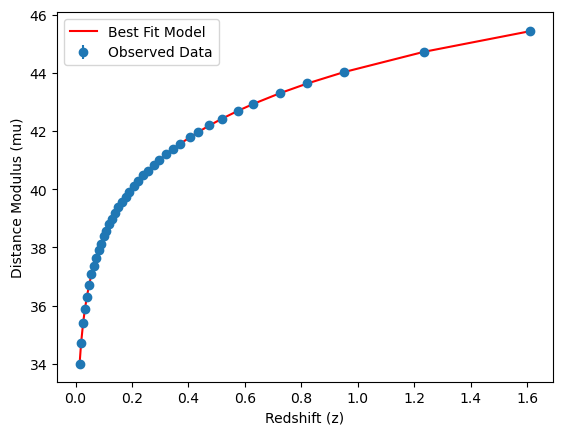

In [24]:
# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best = optimized_params
mu_best = []
for z_prime in z_list:
    mu_best.append(5*np.log10(Dc_w(hubble_function_w, z_prime, Omega_matter_best, Omega_rad_best, Omega_k_best, Omega_L_best, -1, H0_best)*(1+z_prime)) + 25)

# mb is mu +19.3, so:
y = data['mb'].values # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z_list, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()